In [1]:
import pickle
import sys
sys.path.append("..")

from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nsga2.examples.fifa_ultimate_team.crossover import SquadCrossover
from nsga2.examples.fifa_ultimate_team.genotype import Squad
from nsga2.examples.fifa_ultimate_team.initializer import SquadInitializer
from nsga2.examples.fifa_ultimate_team.mutator import SquadMutator
from nsga2.examples.fifa_ultimate_team.stopper import SquadStopper
from nsga2.nsga2.evaluator import Evaluator
from nsga2.nsga2.nsga2 import NSGA2
from nsga2.nsga2.selector import TournamentSelector
from nsga2.nsga2.stopper import MaxGenerationStopper

In [2]:
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["figure.facecolor"] = "black"
plt.rcParams["axes.facecolor"] = "black"
plt.rcParams['text.color'] = "#434343"
plt.rcParams["font.size"] = 16
plt.rcParams['axes.labelcolor'] = "#434343"
plt.rcParams['xtick.color'] = "#434343"
plt.rcParams['ytick.color'] = "#434343"
plt.rcParams['axes.edgecolor'] = "#434343"
plt.rcParams['savefig.facecolor'] = "black"
plt.rcParams['savefig.dpi'] = 100

In [3]:
np.random.seed(25051994)

In [4]:
with open("../nsga2/examples/fifa_ultimate_team/data/processed/players.p", "rb") as file_pointer:
    players = pickle.load(file_pointer)

In [5]:
with open("../nsga2/examples/fifa_ultimate_team/data/processed/formations.p", "rb") as file_pointer:
    formations = pickle.load(file_pointer)

In [6]:
players = players[(players["price"] > 0) & (players["metal"] == "Gold") & (players["revision"] == "Normal")]
formation = formations["42312"]
greater_is_better_dict = {"price": False, "overall": True, "chemistry": True}

In [7]:
initializer = SquadInitializer(1000, formation, players, 2)
evaluator = Evaluator(non_dominated_sorter_kwargs={"greater_is_better_dict": greater_is_better_dict, "max_n_obs": 100}, crowding_distance_sorter_kwargs={"greater_is_better_dict": greater_is_better_dict})
selector = TournamentSelector()
crossover = SquadCrossover(0.2)
mutator = SquadMutator(players, 2, 0.75, 0.7, 0.0, 0.3)
stopper = MaxGenerationStopper(100)

nsga2 = NSGA2(initializer, evaluator, selector, crossover, mutator, stopper)

In [8]:
N_RUNS = 30

In [9]:
population_log = []
for i in tqdm(range(N_RUNS)):
    nsga2.search()
    population_log.append(nsga2.population_log)

100%|██████████| 30/30 [14:09<00:00, 25.26s/it]


In [61]:
eval_df = []
for run_index, run in enumerate(population_log):
    for generation_index, generation in enumerate(run):
        for individual in generation.values():
            temp_dict = dict(individual.phenotype)
            temp_dict["individual_id"] = individual.individual_id
            temp_dict["pareto_front"] = individual.fitness["pareto_front"] if individual.fitness != {} else None
            temp_dict["generation"] = generation_index
            temp_dict["run"] = run_index
            temp_dict["genotype"] = individual.genotype
            eval_df.append(temp_dict)
eval_df = pd.DataFrame(eval_df)
eval_df["performance_ratio"] = eval_df["overall"] * eval_df["chemistry"] / eval_df["price"]

In [62]:
eval_df = eval_df[eval_df["generation"] < 100]

In [63]:
evaluation = eval_df.groupby("generation").agg({"price": ["min", "mean", "max"], "overall": ["min", "mean", "max"], "chemistry": ["min", "mean", "max"], "performance_ratio": ["min", "mean", "max"]})

In [64]:
evaluation_0 = eval_df[eval_df["pareto_front"] == 0].groupby("generation").agg({"price": ["min", "mean", "max"], "overall": ["min", "mean", "max"], "chemistry": ["min", "mean", "max"]})

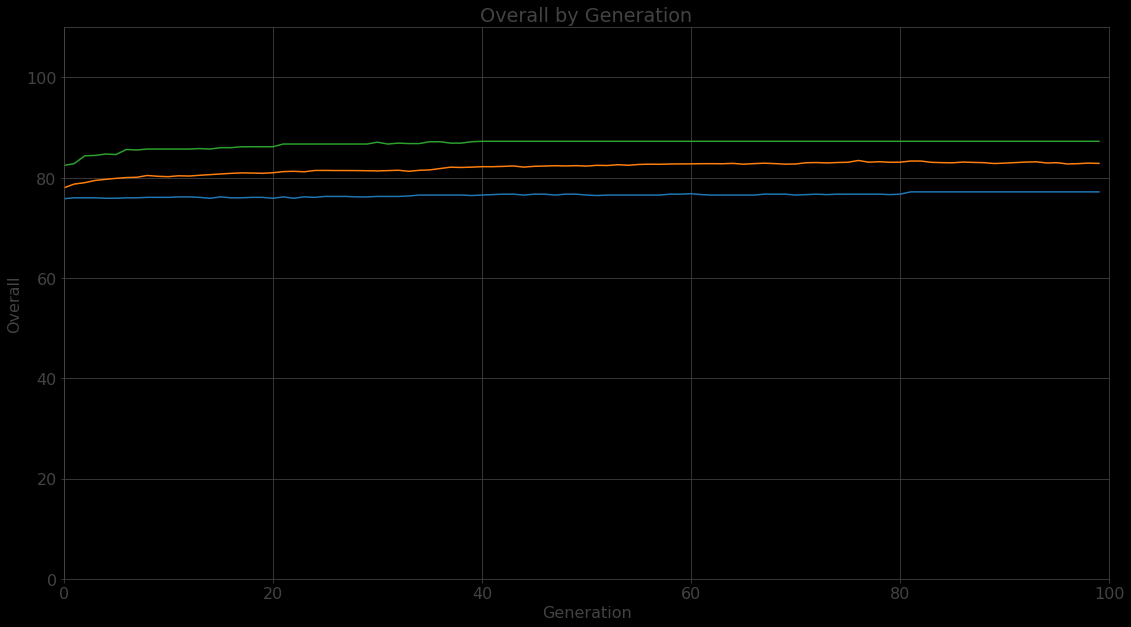

In [65]:
fig = plt.figure()
ax = fig.gca()

evaluation["overall"].plot(ax=ax, zorder=2, legend=None)

ax.grid(True, zorder=0, color="#434343")
ax.set_ylim(0, 110)
ax.set_xlim(0, 100)
ax.set_xlabel("Generation")
ax.set_ylabel("Overall")
ax.set_title("Overall by Generation")

plt.tight_layout()
plt.savefig("../presentation/images/plots/overall_by_generation.png")

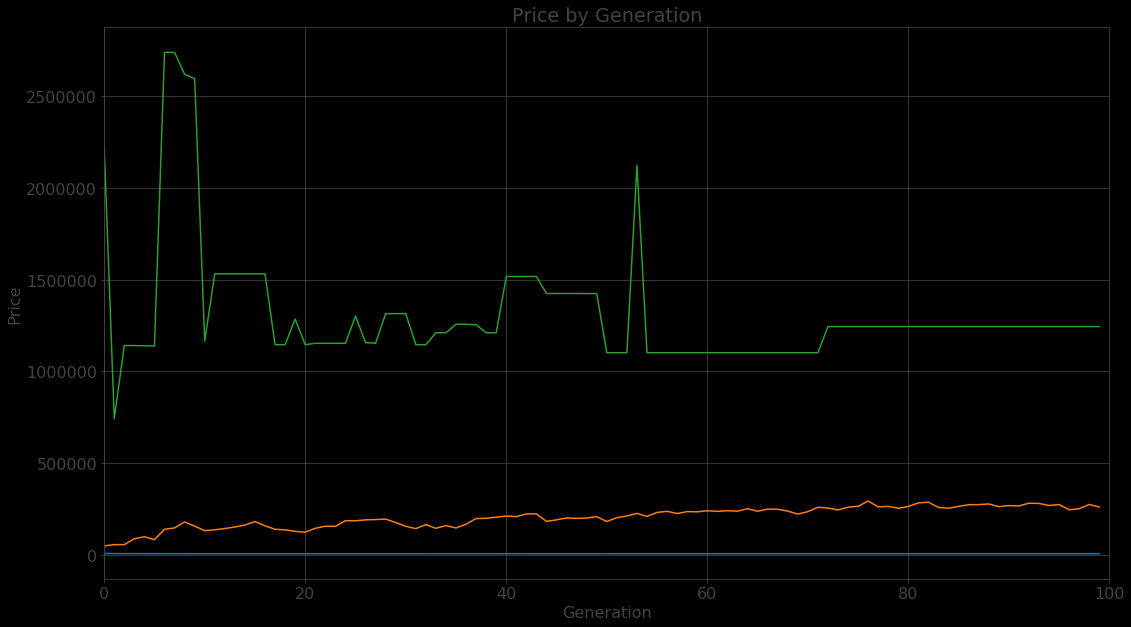

In [66]:
fig = plt.figure()
ax = fig.gca()

evaluation["price"].plot(ax=ax, zorder=2, legend=None)

ax.grid(True, zorder=0, color="#434343")
ax.set_xlim(0, 100)
ax.set_xlabel("Generation")
ax.set_ylabel("Price")
ax.set_title("Price by Generation")

plt.tight_layout()
plt.savefig("../presentation/images/plots/price_by_generation.png")

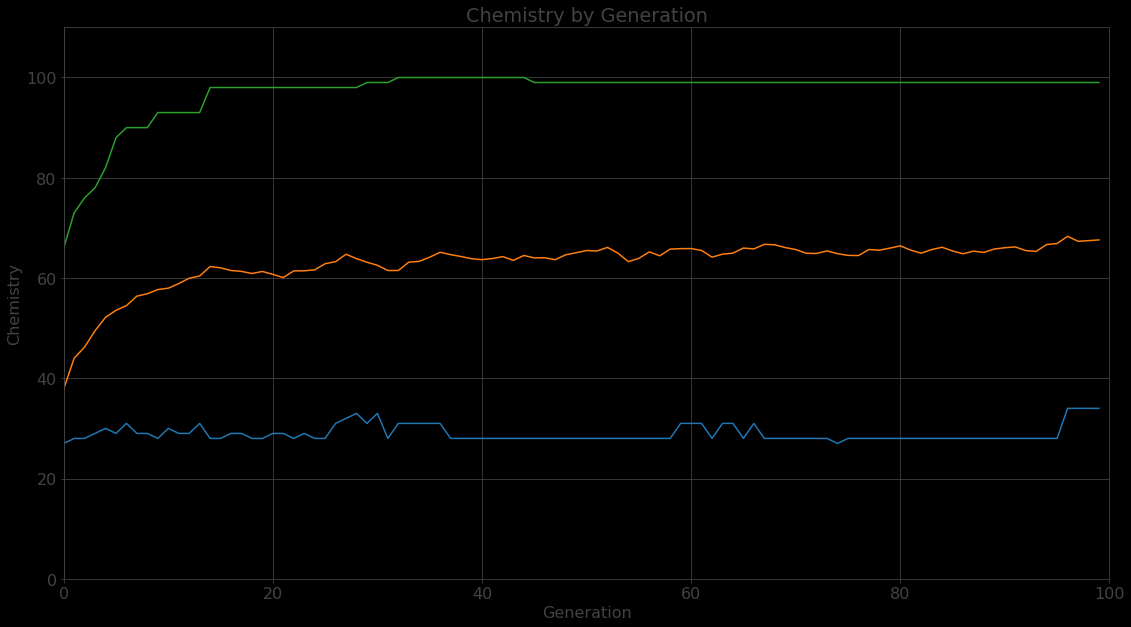

In [67]:
fig = plt.figure()
ax = fig.gca()

evaluation["chemistry"].plot(ax=ax, zorder=2, legend=None)

ax.grid(True, zorder=0, color="#434343")
ax.set_xlim(0, 100)
ax.set_ylim(0, 110)
ax.set_xlabel("Generation")
ax.set_ylabel("Chemistry")
ax.set_title("Chemistry by Generation")

plt.tight_layout()
plt.savefig("../presentation/images/plots/chemistry_by_generation.png")

Text(0, 0.5, 'Overall')

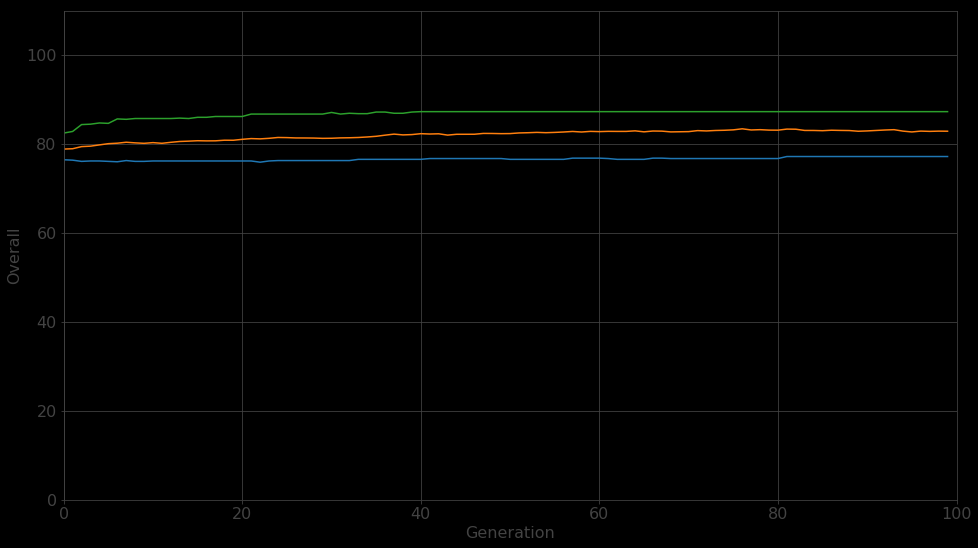

In [68]:
fig = plt.figure()
ax = fig.gca()

evaluation_0["overall"].plot(ax=ax, zorder=2, legend=None)

ax.grid(True, zorder=0, color="#434343")
ax.set_ylim(0, 110)
ax.set_xlim(0, 100)
ax.set_xlabel("Generation")
ax.set_ylabel("Overall")

Text(0, 0.5, 'Price')

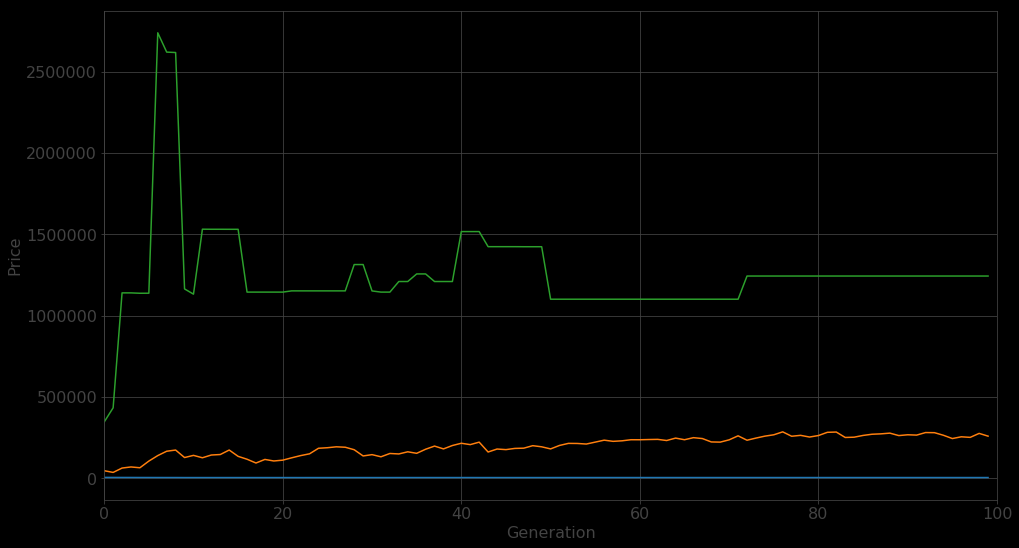

In [69]:
fig = plt.figure()
ax = fig.gca()

evaluation_0["price"].plot(ax=ax, zorder=2, legend=None)

ax.grid(True, zorder=0, color="#434343")
ax.set_xlim(0, 100)
ax.set_xlabel("Generation")
ax.set_ylabel("Price")

Text(0, 0.5, 'Overall')

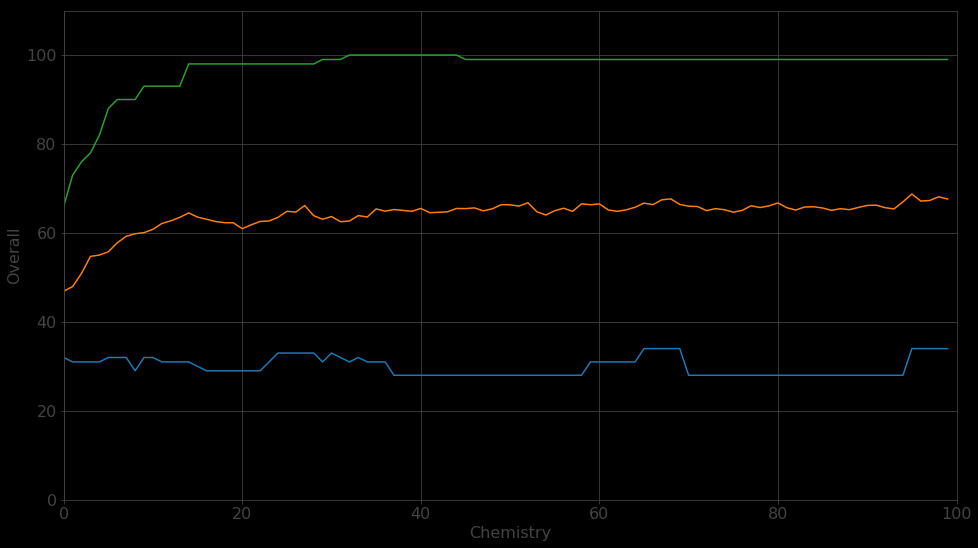

In [70]:
fig = plt.figure()
ax = fig.gca()

evaluation_0["chemistry"].plot(ax=ax, zorder=2, legend=None)

ax.grid(True, zorder=0, color="#434343")
ax.set_ylim(0, 110)
ax.set_xlim(0, 100)
ax.set_xlabel("Chemistry")
ax.set_ylabel("Overall")

In [71]:
pareto_0 = eval_df[(eval_df["pareto_front"] == 0) & (eval_df["generation"] == 99)][["overall", "chemistry", "price", "individual_id"]]

In [ ]:
price = pareto_0["price"]
overall = pareto_0["overall"]
chemistry = pareto_0["chemistry"]

In [ ]:
fig = plt.figure()
ax = fig.gca()

ax.grid(True, zorder=0)
h = ax.scatter(price, overall, c=chemistry, cmap="RdYlGn", vmax=100, vmin=30, zorder=2, s=85)
ax.set_xlabel("Price")
ax.set_ylabel("Overall")

plt.tight_layout()
plt.savefig("../presentation/images/plots/pareto_front_final.png")

In [ ]:
fig = plt.figure()
ax = fig.gca()

ax.grid(True, zorder=0)
h = ax.scatter(price, overall, c=chemistry, cmap="RdYlGn", vmax=100, vmin=30, zorder=2, s=85)
ax.set_xlabel("Price")
ax.set_ylabel("Overall")

ax.set_xlim(0, 100000)

plt.tight_layout()
plt.savefig("../presentation/images/plots/pareto_front_final_zoom.png")

In [78]:
pareto_0[(pareto_0["price"] < 80000) & (pareto_0["overall"] > 82)].sort_values("chemistry", ascending=False)

,overall,chemistry,price,individual_id
1269424,82.181818,98,77300,99424
489248,82.181818,98,77300,99248
3349756,82.181818,98,77300,99756
1659756,82.181818,98,77300,99756
489223,82.181818,98,77300,99223
489227,82.181818,98,77300,99227
1009025,82.181818,98,77300,99025
2179025,82.181818,98,77300,99025
879957,82.181818,98,77300,99957
3349630,82.181818,98,77300,99630


In [82]:
print(eval_df.loc[1269424]["genotype"])

ST:	Player(id=2554, name=Calleri, club=D. Alavés, league=LaLiga Santander, nationality=Argentina, position=ST, overall=77, price=550)
LM:	Player(id=611, name=Marco Asensio, club=Real Madrid, league=LaLiga Santander, nationality=Spain, position=LW, overall=85, price=14000)
CAM:	Player(id=1070, name=Banega, club=Sevilla FC, league=LaLiga Santander, nationality=Argentina, position=CAM, overall=83, price=1400)
RM:	Player(id=364, name=Malcom, club=FC Barcelona, league=LaLiga Santander, nationality=Brazil, position=RW, overall=83, price=3800)
CDML:	Player(id=375, name=Denis Suárez, club=FC Barcelona, league=LaLiga Santander, nationality=Spain, position=CM, overall=79, price=1300)
CDMR:	Player(id=359, name=Vidal, club=FC Barcelona, league=LaLiga Santander, nationality=Chile, position=CDM, overall=85, price=13750)
LB:	Player(id=356, name=Jordi Alba, club=FC Barcelona, league=LaLiga Santander, nationality=Spain, position=LB, overall=87, price=37000)
CBL:	Player(id=913, name=Savic, club=Atlético

In [83]:
formation.labels

{0: 'ST',
 1: 'LM',
 2: 'CAM',
 3: 'RM',
 4: 'CDML',
 5: 'CDMR',
 6: 'LB',
 7: 'CBL',
 8: 'CBR',
 9: 'RB',
 10: 'GK'}

In [118]:
locked_players = {
    2: 194,
    6: 920,
    9: 259
}

In [119]:
initializer = SquadInitializer(1000, formation, players, 2, locked_players=locked_players)
evaluator = Evaluator(non_dominated_sorter_kwargs={"greater_is_better_dict": greater_is_better_dict, "max_n_obs": 100}, crowding_distance_sorter_kwargs={"greater_is_better_dict": greater_is_better_dict})
selector = TournamentSelector()
crossover = SquadCrossover(0.2)
mutator = SquadMutator(players, 2, 0.75, 0.7, 0.0, 0.3)
stopper = MaxGenerationStopper(100)

nsga2 = NSGA2(initializer, evaluator, selector, crossover, mutator, stopper)

In [120]:
population = nsga2.search(verbose=True)

Initialize population...
Run search...
Terminating search...


In [121]:
candidates = [individual for individual in nsga2.population_log[-1].values() if individual.fitness != {} and individual.fitness["pareto_front"] == 0]

In [122]:
cand_df = pd.DataFrame([cand.phenotype for cand in candidates])

In [124]:
cand_df[(cand_df["chemistry"] > 85) & (cand_df["overall"] > 82)].sort_values("price")

,_id,chemistry,overall,price
43,343422,89,82.363636,80600
70,343450,89,82.363636,80600
476,343870,89,82.363636,80600
594,343992,89,82.363636,80600
671,344070,89,82.363636,80600
814,344219,89,82.363636,80600
945,344356,89,82.363636,80600
947,344358,89,82.363636,80600


In [125]:
print(nsga2.population_log[-1][343422].genotype)

ST:	Player(id=512, name=Kane, club=Tottenham Hotspur, league=Premier League, nationality=England, position=ST, overall=89, price=53000)
LM:	Player(id=13297, name=Cristian Tello, club=Real Betis, league=LaLiga Santander, nationality=Spain, position=LM, overall=80, price=950)
CAM:	Player(id=194, name=Kagawa, club=Borussia Dortmund, league=Bundesliga, nationality=Japan, position=CAM, overall=83, price=1400)
RM:	Player(id=396, name=Pedro, club=Chelsea, league=Premier League, nationality=Spain, position=RW, overall=82, price=1500)
CDML:	Player(id=1734, name=Javi García, club=Real Betis, league=LaLiga Santander, nationality=Spain, position=CDM, overall=78, price=1500)
CDMR:	Player(id=391, name=Kovacic, club=Chelsea, league=Premier League, nationality=Croatia, position=CM, overall=83, price=2300)
LB:	Player(id=920, name=Hernández, club=Atlético Madrid, league=LaLiga Santander, nationality=France, position=LB, overall=82, price=7100)
CBL:	Player(id=3136, name=Perrin, club=AS Saint-Étienne, lea